In [19]:
import sys
# add didgelab source code to path
sys.path.append('../../')

from cad.calc.parameters import MutationParameterSet, MutationParameter
from cad.ui.visualization import DidgeVisualizer
import numpy as np
from cad.calc.geo import Geo, geotools
import sys


100%|██████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.18it/s]

D#1    6
B1     5
F#1    5
E1     5
G0     5
A#2    4
G#1    3
F1     3
C1     2
A1     2
D1     2
A#1    2
G#0    2
F#0    1
A2     1
G1     1
C#1    1
Name: note-name, dtype: int64

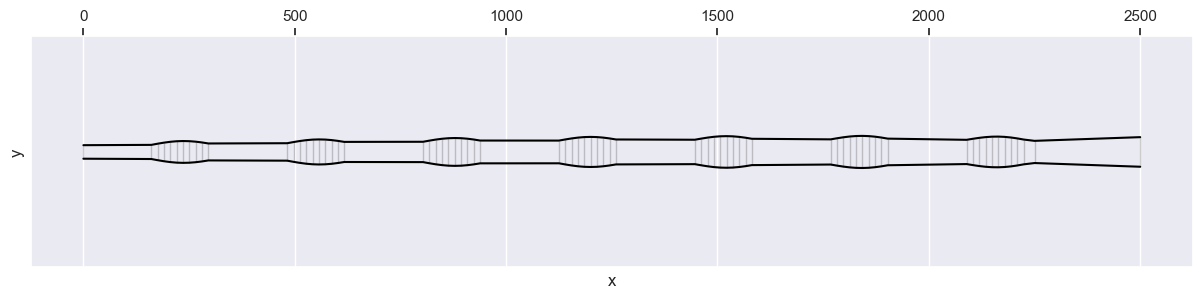

In [119]:
class EriceiraShape(MutationParameterSet):
    
    def __init__(self):
        
        MutationParameterSet.__init__(self)

        self.d1=32
        
        self.n_bubbles=7
        self.n_bubble_segments=10
        
        self.add_param("length", 1500, 3500)
        self.add_param("bellsize", 60, 80)
        self.add_param("bell_length", 200, 300)
        self.add_param("pre_bell_diameter", 0.7, 0.8)
        
        
        for i in range(self.n_bubbles):
            self.add_param(f"bubble{i}_width", 100, 200)
            self.add_param(f"bubble{i}_height", 5, 30)
            self.add_param(f"bubble{i}_pos", -0.3, 0.3)

    def make_geo(self):
        length = self.get_value("length")
        bellsize = self.get_value("bellsize")
        bell_length = self.get_value("bell_length")
        shape = [
            [0, self.d1],
            [length-bell_length, bellsize * self.get_value("pre_bell_diameter")],
            [length,bellsize]
        ]
        
        bubble_length = length-bell_length
        for i in range(self.n_bubbles):
            
            width = self.get_value(f"bubble{i}_width")
            height = self.get_value(f"bubble{i}_height")
            pos = self.get_value(f"bubble{i}_pos")
                
            x = width * np.arange(self.n_bubble_segments)/self.n_bubble_segments
            y = height * np.sin(np.arange(self.n_bubble_segments)*np.pi/self.n_bubble_segments)
            
            x += bubble_length * i/self.n_bubbles
            x += (0.5+pos)*bubble_length/self.n_bubbles
                        
            if x[0] < 0:
                x += -1*x[0]
                x += 1
            if x[-1] > bubble_length:
                x -= x[-1] - (bubble_length)
            
            geo = Geo(shape)
            y += np.array([geotools.diameter_at_x(geo, _x) for _x in x])
            
            shape = list(filter(lambda a : a[0]<x[0] or a[0]>x[-1], shape))
            shape.extend(zip(x,y))
            shape = sorted(shape, key=lambda x : x[0])
            

        return Geo(shape)
        
father = EriceiraShape()

geo = father.make_geo()
DidgeVisualizer.vis_didge(geo)

#cadsd = CADSD(mutant.make_geo())
#impedance_spectrum=cadsd.get_impedance_spektrum()
#sns.lineplot(data=impedance_spectrum, x="freq", y="impedance")

# compute 50 cadsds and get the distribution of their fundamental notes
from cad.calc.mutation import ExploringMutator
import pandas as pd
import tqdm
mutator = ExploringMutator()

mutants = []
geos = []

n=50
pbar = tqdm.tqdm(total=n)
for i in range(n):
    mutant = father.copy()
    mutator.mutate(mutant)
    mutants.append(mutant)
    geo = mutant.make_geo()
    geos.append(geo)
    geo.get_cadsd().get_notes()
    pbar.update()
    
from cad.calc.conv import note_to_freq

fD = note_to_freq(-31)

def get_closest_note(geo, f):
    notes = geo.get_cadsd().get_notes()
    freqs = np.abs(np.log2(notes.freq) - np.log2(f))
    return notes.iloc[np.argmin(freqs)]

fundamentals = [get_closest_note(g, fD) for g in geos]
fundamentals = pd.DataFrame(fundamentals)
fundamentals["note-name"].value_counts()

<AxesSubplot: xlabel='length', ylabel='fundamental'>

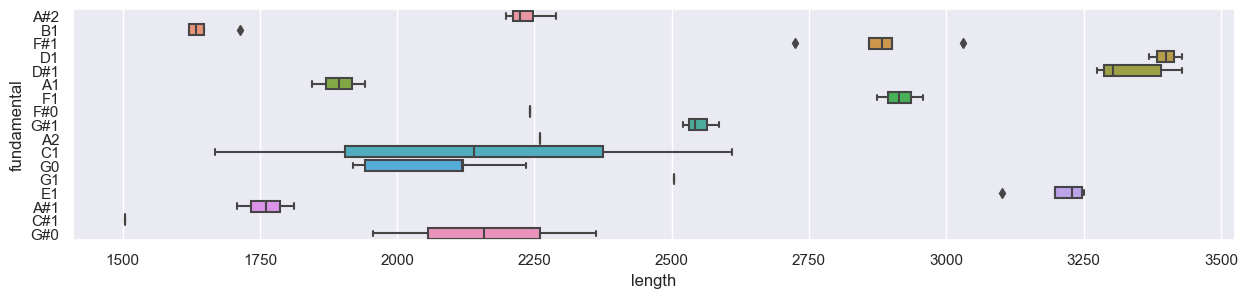

In [121]:
import seaborn as sns
df = []
for i in range(len(fundamentals)):
    df.append({
        "fundamental": fundamentals.iloc[i]["note-name"],
        "length": geos[i].geo[-1][0]
    })
df = pd.DataFrame(df)

sns.boxplot(data=df, x="length", y="fundamental")

<AxesSubplot: xlabel='length', ylabel='note-name'>

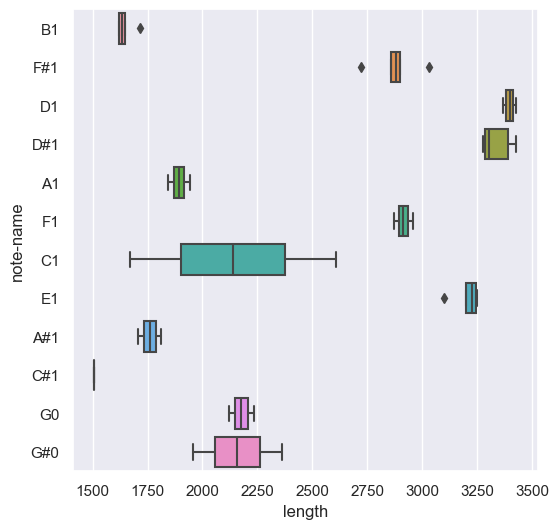

In [136]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))

f = fundamentals.copy()
f["length"] = [g.geo[-1][0] for g in geos]
f=f.query("95>freq>50")
sns.boxplot(data=f, x="length", y="note-name")

In [104]:
f = fundamentals.reset_index()
f = f[f["note-name"]=="F1"]
g = [geos[i] for i in f.index]
for x in g:
    print(x.geo[-1][0])

g[0].get_cadsd().get_notes()

3028.6928468278625
2971.4757255513478
3038.1628829600554
3076.079817974304
3158.2545069369467


,freq,impedance,rel_imp,note-number,cent-diff,note-name
1298,33.9,1.186653e+07,1.000000,-44,37.775614,C#0
1838,87.9,1.022045e+07,0.861284,-28,-11.717856,F1
111,141.0,4.684325e+06,0.394751,-20,-29.829967,C#2
175,205.0,7.748615e+06,0.652980,-13,22.255537,G#2
224,254.0,7.045172e+06,0.593701,-10,-48.789968,B3
274,304.0,2.871443e+06,0.241978,-6,40.118640,D#3
320,350.0,4.364493e+06,0.367798,-4,-3.821678,F3
393,423.0,8.915813e+06,0.751341,-1,-31.784968,G#3
445,475.0,2.232254e+06,0.188113,1,-32.508788,A#4
504,534.0,4.320103e+06,0.364058,3,-35.203462,C4


In [87]:
def get_closest_note(geo, f):
    notes = geo.get_cadsd().get_notes()
    freqs = np.abs(np.log2(notes.freq) - np.log2(f))
    return notes.iloc[np.argmin(freqs)]


In [86]:
f = fundamentals.reset_index()
f = f[f["note-name"]=="D1"]
g = [geos[i] for i in f.index]

for x in g:
    print(x.geo[-1][0])


3448.7673828550546
3468.0504016695095
3362.839409818921
3446.9796902161634


In [70]:
from cad.calc.conv import note_to_freq

fD = note_to_freq(-31)

def get_closest_note(geo, f):
    notes = geo.get_cadsd().get_notes()
    freqs = np.abs(np.log2(notes.freq) - np.log2(f))
    return notes.iloc[np.argmin(freqs)]

fundamentals = [get_closest_note(g, fD) for g in geos]
fundamentals = pd.DataFrame(fundamentals)
fundamentals["note-name"].value_counts()

G1     7
D#1    7
G#1    7
F#1    6
F1     5
E1     4
A2     3
F#0    2
G0     2
G#0    2
A1     2
A#2    1
D1     1
A#1    1
Name: note-name, dtype: int64